In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [6]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv('SeoulBikeData.csv').drop(['Date','Holiday', 'Seasons'], axis=1)

In [15]:
df.columns = dataset_cols
df['functional'] = (df["functional"] == "Yes").astype(int)
df = df[df["hour"] == 12]
df = df.drop(["hour"], axis=1)

In [16]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,0
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,0
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,0
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,0
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,0


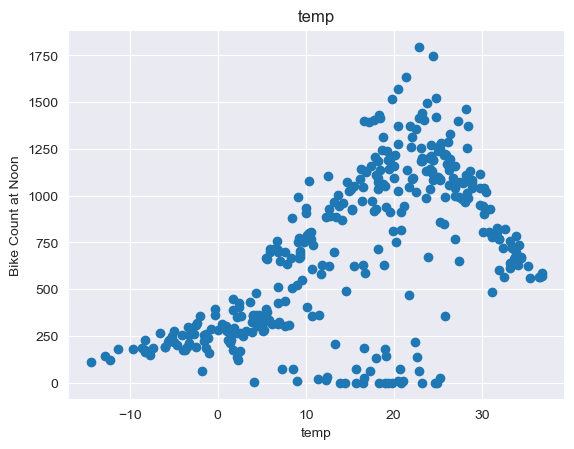

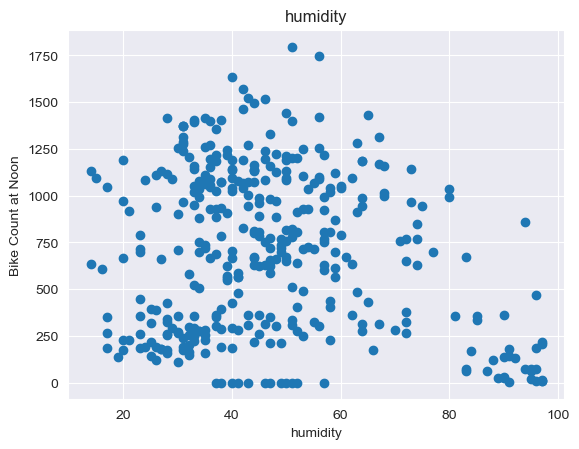

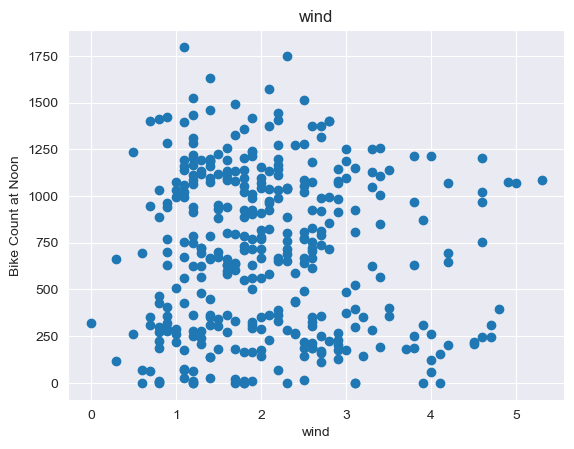

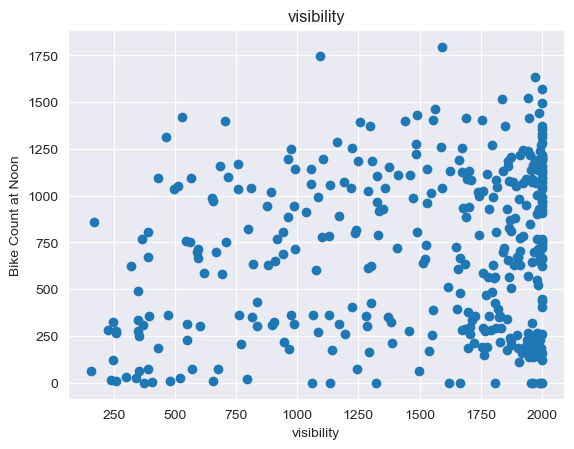

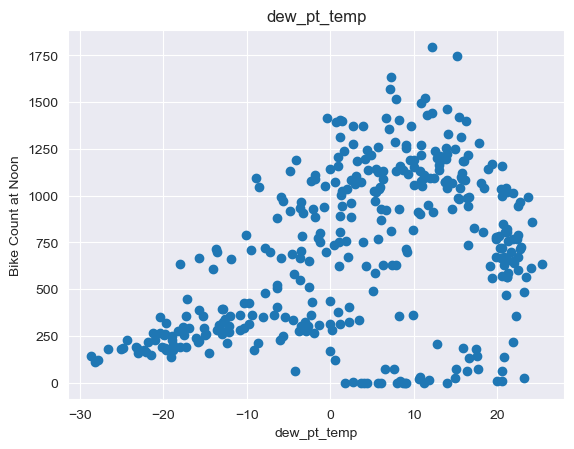

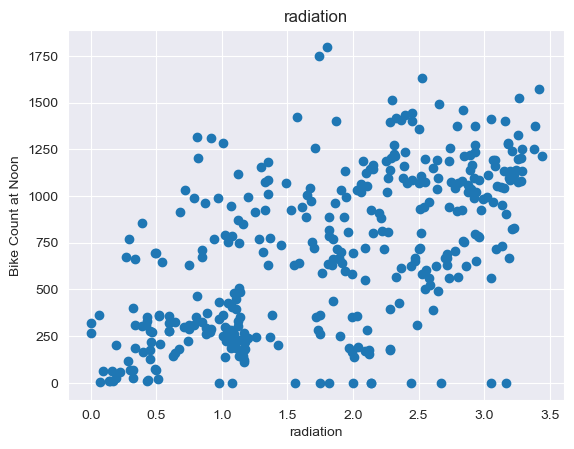

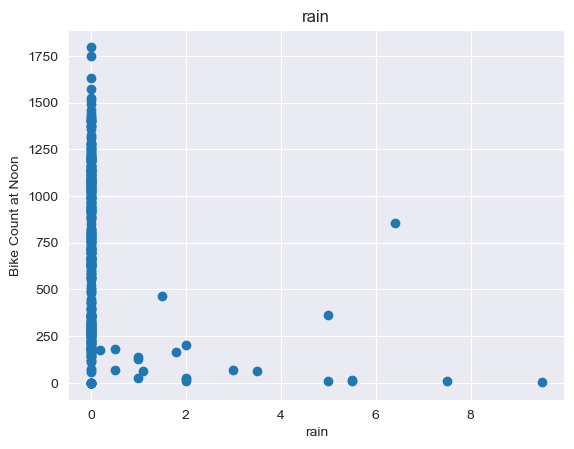

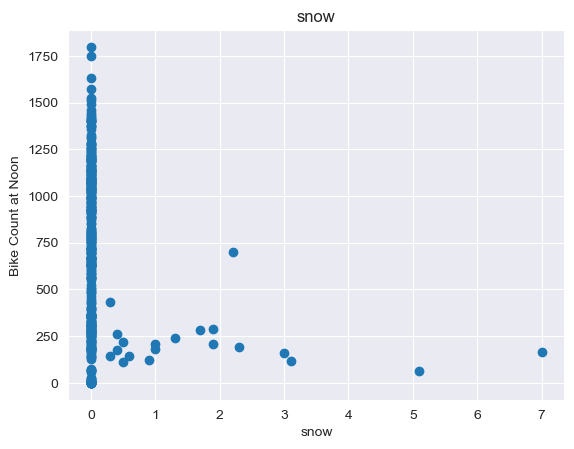

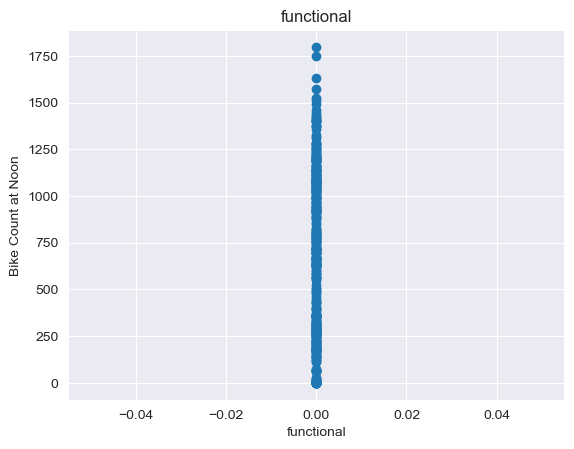

In [17]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["bike_count"])
    plt.title(label)
    plt.ylabel("Bike Count at Noon")
    plt.xlabel(label)
    plt.show()

In [18]:
df= df.drop(["wind", "visibility", "functional"], axis = 1)

In [19]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


In [35]:
#train/valid/test dataset
train, val, test = np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])

In [36]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1,1)
        else:
            X = dataframe[x_labels].values
    
    y = dataframe[y_label].values.reshape(-1,1)
    data = np.hstack((X,y))
    
    return data, X, y

In [37]:
_, X_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, X_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, X_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [38]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [39]:
temp_reg.score(X_test_temp, y_test_temp)

0.4037714412218779

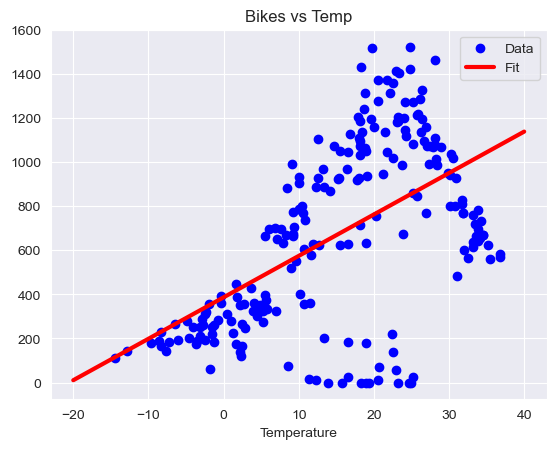

In [40]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20,40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1,1)), label="Fit", color = "red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.y_label = "Number of bikes"
plt.xlabel("Temperature")
plt.show()

In [41]:
#multiple linear regression
_, X_train, y_train = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, X_val, y_val = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, X_test, y_test = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [42]:
all_reg = LinearRegression()
all_reg.fit(X_train, y_train)

LinearRegression()

In [43]:
all_reg.score(X_test,y_test)

0.4752377421670869

In [62]:
##NN
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

C:\Users\paulk\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [63]:
history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0, epochs=100
)

In [64]:
def plot_loss(history):
    plt.plot(history.history['loss'], label="Loss")
    plt.plot(history.history['val_loss'], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

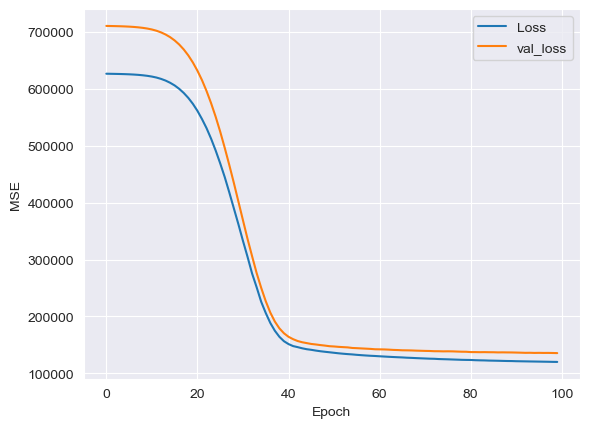

In [65]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


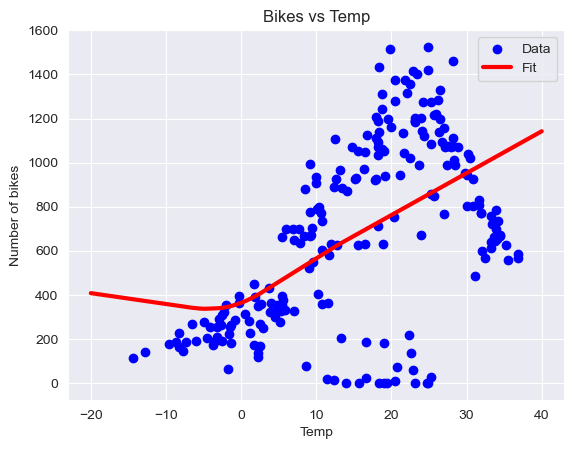

In [66]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Temp")
plt.show()

In [67]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(X_train)

C:\Users\paulk\anaconda3\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [69]:
history = nn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    verbose=0, epochs=100
)

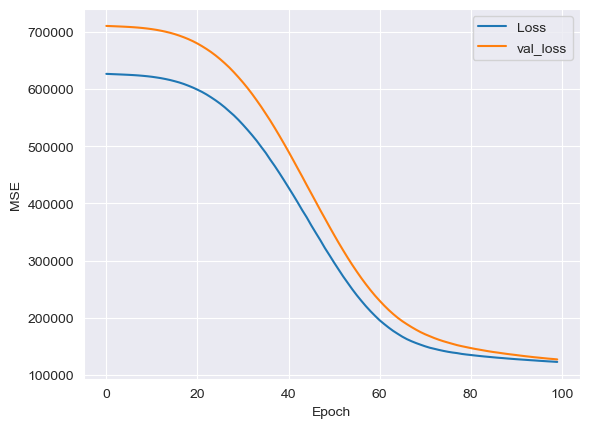

In [70]:
plot_loss(history)